## End member mixing analysis (EMMA) to determine streamflow source contributions
## PLOTS for WRR submission

### EMMA Step #3: solving EMM models using SciPy sequential least squares quadratic optimization.​

#### This analysis starts from solute data from Wade Brook late winter/early spring flow events captured with ISCOs. Data include:
- base cations from ICP-OES measurements: Al, Ca, Cu, Fe, K, Mg, Mn, Na, P, Zn, Si
- base anions from IC measurements: Cl, F, Br (NO2, NO3, SO4 also from IC - I reject the PO4 from IC)
- nutrient concentrations from total elemental analyzer: SO4, NO3, PO4, DIN
- total organic carbon (TOC) from total elemental analyzer
- stable water isotopes (dD, d18O)

Data are all in the Winter Watershed OneDrive directory under Documents\Link to LCBP Data (Sharepoint)/LCBP_EMMA

- For Hungerford and Wade 2023 timeseries, 17 parameters total
- For Hungerford, 5 were found to be relatively conservative: dD, Ca, Na, d18O, and Mg
- See EMMA Step #1 ["bivariates" notebook](https://github.com/MeganEDuffy/EMMA/blob/main/EMMA/Wade_2023_ISCO_bivariates.ipynb) and EMMA Step #2 [PCA notebook](https://github.com/MeganEDuffy/EMMA/blob/main/EMMA/Wade_2023_ISCO_PCA.ipynb) for the above work and figures. 
- This is a standalone script, it builds on EMMA Steps #1 and #2 but is run from the original data.

This code utilizes the minimize function from SciPy to find fractions that meet the specified constraints. The objective function minimizes the difference between the observed and predicted observations, subject to the constraints on the fractions.

### TO DO (last updated 2025-06-04):

- [ ] Adaptive endmember read in for event and site within single origin CSV
        - Function to read in EMs, normalize and do PCA, then EMMA and fractional cont balance
- [ ] Maybe use a [stacked line plot](https://stackoverflow.com/questions/2225995/how-can-i-create-stacked-line-graph) instead, sort of like Fuss et al.
- [x] Add snowpack depth and rainfall optional subplot
    - Using CoCoRAHS Montgomery station, which is low in the watershed but best we can do (better than Mt. Mansfield)
- [ ] Add soil moisture/soil temp to fourth panel
    - We have soil temp and VWC from J. Faulkner's Swanton sites until 2023-03-28, so not our complete dataset
    - The HD1 can fill in also for VWC and 15 cm
- [x] Read in more recent q chem data from SV. No difference expected but complete WY22 and WY23 dataset.
    - I put in LCBP_Soils OriginalData directory

In [1]:
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

## Event AB: February rain

<>:411: SyntaxWarning: invalid escape sequence '\c'
<>:411: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_52068/20923621.py:411: SyntaxWarning: invalid escape sequence '\c'
  ax4.set_ylabel('Soil temperature ($^\circ$C)', color='black', fontsize = 12)


Tracers are ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L'].
Saved plot to: output/Wade_Events_A,B_Feb_9-11;16-17,_2023.jpg


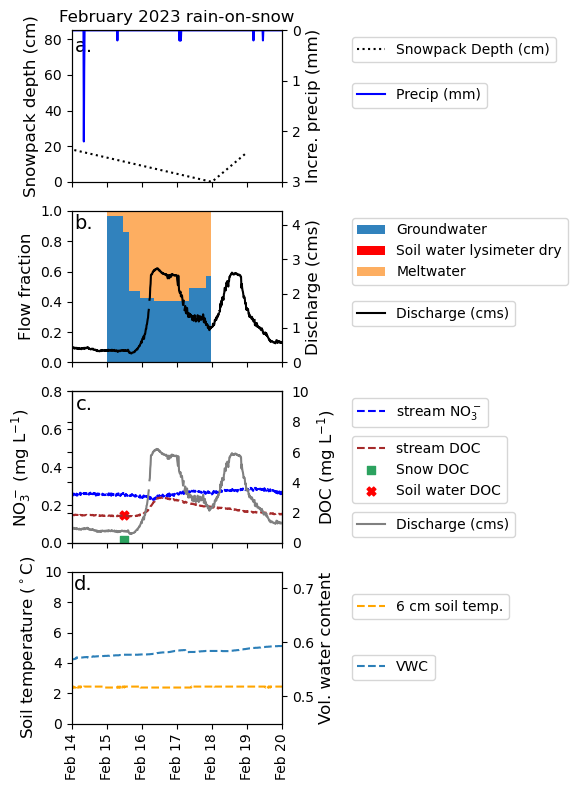

In [22]:
###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#################################
# Set site, tracers, endmembers #
#################################

Site = 'Wade'
Month = 'February'
#Month = 'March'
#Month = 'April'

# Tracers

if Site == 'Hungerford':
    tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']
    
if Site == 'Wade':
    tracers = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']
    
print(f"Tracers are {tracers}.")

# Endmembers
if Month == 'February':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
    
if Month == 'March':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
    
if Month == 'April':
    em_data = em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D
    

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-toc-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == Site) & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # If excluding pre-event
em_data = em_data[~em_data['Type'].isin(['Groundwater Bear Pond'])] # If using GW ave at Wade
em_data = em_data[~em_data['Type'].isin(['Groundwater High Pond'])] # If using GW ave at Wade
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs
em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter wet'])] # If using ave
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter dry'])] # If using ave

# Load soil water and snowmelt DOC data from csv just for plotting
# The dates are artifical, but useful to fit on the EMMA time scales
em_toc_data = pd.read_csv("data/newrnet-chemistry/RI23-endmember-doc-plotting.csv")
em_toc_data = em_toc_data.loc[
    (em_toc_data['Site'] == Site)
]
em_toc_data['Datetime'] = (em_toc_data['Date'] + ' ' + em_toc_data['Time'])
em_toc_data['Datetime'] = pd.to_datetime(em_toc_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
# Define mapping of marker, color, and label by column Type
type_styles = {
    'Soil water lysimeter': {
        'color': 'red',
        'marker': 'X', # x marker
        'label': 'Soil water DOC'
    },
    'Snow': {
        'color': '#2ca25f',
        'marker': 's',  # square
        'label': 'Snow DOC'
    }
}

#########################################################
# Load + clean the s::can, snowpack, met, and soil data #
#########################################################

# Load q and s::can NO3 + TP data from csv
# Compelete WY22 & WY23 dataset from SV, sent in May 2025
scan_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/OriginalData/stream-scan/wb_q_chem_20211001-20230930.csv")

# Load scan_TOC data (mg/L) from csv
# Downloaded from Aquarius 05-19-2025 MED
toc_data = pd.read_csv("~//OneDrive/git-repos/EMMA/data/newrnet-q-scan/DOC.DOC@Wade_Brook.20221001.csv", comment='#')

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)
toc_data['ISO 8601 UTC'] = pd.to_datetime(toc_data['ISO 8601 UTC']).dt.tz_convert(None)

# Rename TOC columns for consistency
toc_data.rename(columns={'ISO 8601 UTC': 'datetime', 'Value': 'TOC'}, inplace=True)

# Load snowpack depth data from Mt Mansfield snow stake
#snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/snowpack/data/mansfield-noaa-WY22-WY23-3855342.csv")
#snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['DATE'], format="%Y-%m-%d %H:%M", errors="coerce")

# Load snowpack depth data from CoCoRaHS
snowpack_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/CleanedData/met-station/clean-cocorahs-vt-fr-30-20221115-20250414.csv")
snowpack_data['Date_clean'] = snowpack_data['Date'].str.strip()
snowpack_data['datetime'] = pd.to_datetime(snowpack_data['Date_clean'], format="%m/%d/%Y", errors="coerce")

# Load met data including precip
met_data = pd.read_csv("~//OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/wade_2020-2024_met_2024-11-08.csv")
met_data['Datetime'] = pd.to_datetime(met_data['Timestamp'], format = "%Y-%m-%d %H:%M:%S", errors = 'coerce')
met_data = met_data[met_data['Precip_Increm'].notna()] # Lots of missing (NA) precip in WWY23

# Load soil temperature and moisture data from Ranch Brook (Mansfield) SML1 site
soil_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/OriginalData/soil-sensors/Ranch_Brook/RanchBrook_TMS4_WY23_SML1_data.csv")
soil_data = soil_data.rename(columns={'Soil_temp': 'Temperature'})
soil_data['Datetime'] = pd.to_datetime(soil_data['dateTimeText'], format = "%Y.%m.%d %H:%M", errors = 'coerce')
filtered_1_soil = soil_data[soil_data['TMS_MED_number'] == 1]
filtered_2_soil = soil_data[soil_data['TMS_MED_number'] == 2]
filtered_3_soil = soil_data[soil_data['TMS_MED_number'] == 3]
filtered_4_soil = soil_data[soil_data['TMS_MED_number'] == 4]

#########
# PCA  #
#########

# Select the specific parameters from Site section (tracers)
selected_parametesr = tracers

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + tracers]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=tracers)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[tracers]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[tracers]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)

#######################
# VISUALIAZE THE EMMA #
#######################

# Filter data for samples in Event A
eventA_df = fractions_df[(fractions_df['Datetime'] >= '02/09/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/18/2023 00:00')]

#eventA_range = # Set x-axis limits for plot scope
start_A = pd.to_datetime("2023-02-09 00:00:00")
end_A = pd.to_datetime("2023-02-20 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_A = pd.to_datetime("2023-02-14 00:00:00")
end_plot_A = pd.to_datetime("2023-02-20 00:00:00")

# Filter data for samples in Event C
eventC_df = fractions_df[(fractions_df['Datetime'] >= '03/21/2023 00:00') \
                         & (fractions_df['Datetime'] <= '03/26/2023 00:00')]

#eventC_range = # Set x-axis limits for plot scope
start_C = pd.to_datetime("2023-03-21 00:00:00")
end_C = pd.to_datetime("2023-03-26 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_C = pd.to_datetime("2023-03-22 00:00:00")
end_plot_C = pd.to_datetime("2023-03-26 00:00:00")

# Filter data for samples in Event D
eventD_df = fractions_df[(fractions_df['Datetime'] >= '03/30/2023 00:00') \
                         & (fractions_df['Datetime'] <= '04/12/2023 00:00')]

#eventD_range = # Set x-axis limits for plot scope
start_D = pd.to_datetime("2023-03-30 00:00:00")
end_D = pd.to_datetime("2023-04-12 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_D = pd.to_datetime("2023-03-31 00:00:00")
end_plot_D = pd.to_datetime("2023-04-03 00:00:00")

# Set 'Datetime' as the index
eventA_df.set_index('Datetime', inplace=True)
eventC_df.set_index('Datetime', inplace=True)
eventD_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors_A = {'Groundwater ave': '#3182bd', \
          #'Soil water lysimeter wet': '#fa9fb5', \
          #'Soil water lysimeter dry': 'red',\
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}#,\
          #'Pre-event': '#3182bd'}

# Define colors for each endmember
colors_C = {'Groundwater': '#3182bd', \
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}\
          #'Pre-event': '#3182bd' }

# Define colors for each endmember
colors_D = {'Groundwater': '#3182bd', \
          'Soil water lysimeter wet': '#fa9fb5', \
          'Soil water lysimeter dry': 'red',\
          'Precip': '#3182bd',\
          'Snowmelt lysimeter 3/28': '#fdae61',\
          'Snowmelt lysimeter 4/12': '#ffeda0'}\
          #'Pre-event': '#3182bd' }

def plot_event_with_snowpack(
    event_df, event_name, colors, start, end, start_plot, end_plot, scan_data, snowpack_data, figsize=(6.5, 8)
):
    """
    Creates two stacked subplots:
    - Top: Snowpack depth and (eventually) rainfall data with two y-axes.
    - Bottom: Flow fractions, discharge, and nitrate.

    Parameters:
    - event_df: DataFrame containing data for the event, with Datetime as the index.
    - event_name: Name of the event (str) to use in the plot title.
    - colors: Dictionary mapping endmembers to colors.
    - start: Start datetime for the event.
    - end: End datetime for the event.
    - scan_data: DataFrame containing discharge and nitrate data.
    - snowpack_data: DataFrame containing snowpack depth data.
    - figsize: Tuple specifying figure size.
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=figsize, sharex=True)

    # Add subplot annotations in top-right corner using Axes coordinates
    ax1.annotate('a.', xy=(0.1, 0.86), xycoords='axes fraction', fontsize=14, ha='right')
    ax2.annotate('b.', xy=(0.1, 0.88), xycoords='axes fraction', fontsize=14, ha='right')
    ax3.annotate('c.', xy=(0.1, 0.88), xycoords='axes fraction', fontsize=14, ha='right')
    ax4.annotate('d.', xy=(0.1, 0.88), xycoords='axes fraction', fontsize=14, ha='right')

    ### Top subplot: Snowpack and eventually rainfall ###
    # Filter snowpack + rainfall data for the event duration
    snowpack_event = snowpack_data[(snowpack_data['datetime'] >= start) & (snowpack_data['datetime'] <= end)]
    precip_event = met_data[(met_data['Datetime'] >= start) & (met_data['Datetime'] <= end)]

    # Plot snowpack data on the primary y-axis
    ax1.plot(snowpack_event['datetime'], snowpack_event['snowpack_cm'], color='black', label='Snowpack Depth (cm)', linestyle=':')
    ax1.set_ylabel('Snowpack depth (cm)', color='black', fontsize = 12)
    ax1.set_ylim([0, 85])
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a secondary y-axis for rainfall
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(met_data['Datetime'], met_data['Precip_Increm'], color='blue', label='Precip (mm)')
    ax1_secondary.invert_yaxis()
    ax1_secondary.set_ylim([3, 0])
    ax1_secondary.set_ylabel('Incre. precip (mm)', color='black', fontsize = 12)
    ax1_secondary.tick_params(axis='y', labelcolor='black')
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.24, 0.8))

    # Set labels and legend
    #ax1.set_title(f'Snowpack depth and rainfall during {event_name}')
    ax1.set_title('February 2023 rain-on-snow', fontsize = 12)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.24, 1))

    ### Middle subplot: Flow fractions + discharge ###
    bottom = None
    for column, color in colors.items():
        ax2.bar(event_df.index, event_df[column], label=column, color=color, bottom=bottom, width=1)
        if bottom is None:
            bottom = event_df[column].values
        else:
            bottom += event_df[column].values

    # Map original column names to simplified legend labels
    legend_labels = {
    'Groundwater ave': 'Groundwater',
    'Baseflow': 'Groundwater',
    'Soil water lysimeter ave': 'Soil water',
    'Snowmelt lysimeter': 'Meltwater',
    'Snowmelt lysimeter ave': 'Meltwater'
    }

    # Build custom legend handles with simplified labels
    handles, labels = ax2.get_legend_handles_labels()
    simplified_labels = [legend_labels.get(lbl, lbl) for lbl in labels]

    #ax2.set_xlabel('Datetime')
    ax2.set_xlabel('')
    ax2.set_ylabel('Flow fraction', fontsize=12)
    ax2.set_xlim([start_plot, end_plot])
    ax2.legend(loc='upper left', bbox_to_anchor=(1.24, 1))
    #ax2.set_title(f'Fractional endmember contributions during {event_name}')
    ax2.tick_params(axis='x', rotation=30)

    # Secondary y-axis for discharge
    ax2_secondary = ax2.twinx()
    ax2_secondary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='black', label='Discharge (cms)', linestyle='-')
    ax2_secondary.set_ylabel('Discharge (cms)', color='black', fontsize = 12)
    ax2_secondary.set_ylim(0,4.4)
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.24, 0.55))

    # Plot discharge (again), NO3, and TOC on lower plot
    # Primary y-axis for nitrate
    ax3.plot(scan_data['datetime'], scan_data['NO3'], color='blue', label='stream NO$_3^-$', linestyle='--')
    ax3.set_ylabel('NO$_3^-$ (mg L$^{-1}$)', color='black', fontsize = 12)
    ax3.set_ylim(0,0.8)
    ax3.legend(loc='upper left', bbox_to_anchor=(1.5, 0.6))

    # Secondary y-axis for stream DOC
    ax3_secondary = ax3.twinx()
    ax3_secondary.plot(toc_data['datetime'], toc_data['TOC'], color='brown', label='stream DOC', linestyle='--')
    #ax3_secondary.scatter(streamwater_data['Datetime'], streamwater_data['TOC mg_L'], color = 'black', s = 10, label='Stream DOC')
    # Plot each type separately
    for t, group in em_toc_data.groupby('Type'):
        if t in type_styles:
            style = type_styles[t]
            ax3_secondary.scatter(
                group['Datetime'],
                group['TOC_mg_L'],
                color=style['color'],
                marker=style['marker'],
                s=40,
                label=style['label']
            )
    ax3_secondary.set_ylabel('DOC (mg L$^{-1}$)', color='black', fontsize = 12)
    ax3_secondary.set_ylim(0,10)

    # Tertiary axis for discharge (greyed out, no axis label needed)
    ax3_tertiary = ax3_secondary.twinx()
    ax3_tertiary.spines.right.set_position(("axes", 1.0))
    ax3_tertiary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='grey', label='Discharge (cms)', linestyle='-')
    ax3_tertiary.set_ylim([0, 4.4])
    ax3_tertiary.tick_params(axis='y', labelcolor='white')
    ax3_tertiary.set_yticks([])
    ax3_tertiary.tick_params(axis='x', rotation=90, color = 'white')
    
    # Fix secondary y-axis tick alignment after creating the tertiary axis
    ax3_secondary.tick_params(axis='y', labelright=True, labelleft=False)

    # Plot soil temperature and moisture on 4th plot
    ax4.plot(filtered_2_soil['Datetime'], filtered_2_soil['Temperature'], color='orange', label='6 cm soil temp.', linestyle='--')
    ax4.set_ylabel('Soil temperature ($^\circ$C)', color='black', fontsize = 12)
    ax4.set_ylim([0, 10])
    ax4.tick_params(axis='y', labelcolor='black')
    ax4.tick_params(axis='x', rotation=90)
    ax4.legend(loc='upper left', bbox_to_anchor=(1.25, 0.65))

    # Secondary y-axis for soil VWR
    ax4_secondary = ax4.twinx()
    ax4_secondary.spines.right.set_position(("axes", 1.0))
    ax4_secondary.plot(filtered_4_soil['Datetime'], filtered_4_soil['VWC'], color='#2c7fb8', label='VWC', linestyle='--')
    ax4_secondary.set_ylabel('Vol. water content', color='black', fontsize = 12)
    ax4_secondary.set_ylim(0.45,0.73)
    ax4_secondary.legend(loc='upper left', bbox_to_anchor=(1.25, 0.25))

    # Plot all legends (overwrites some bad legend positions above)
    # Before plotting legends, shrink the plotting area to make space on the right
    plt.subplots_adjust(right=0.75)

    # Then fix all legends with the same x anchor
    ax1.legend(loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.7))

    ax2.legend(handles, simplified_labels, loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.45))

    ax3.legend(loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax3_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.75))
    ax3_tertiary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.25))

    ax4.legend(loc='upper left', bbox_to_anchor=(1.30, 0.9))
    ax4_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.5))

    # Define the formatter
    date_fmt = mdates.DateFormatter('%b %d')  # e.g., 'Feb 09'

    # Apply to all x-axes
    for ax in [ax1, ax2, ax3, ax4]:
        ax.xaxis.set_major_formatter(date_fmt)

    plt.tight_layout()

    # --- Save plot as 'output/Site_EventName.jpg' ---
    # Sanitize filename: replace spaces and parentheses
    safe_event_name = event_name.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "")
    filename = f"{Site}_{safe_event_name}.jpg"
    output_path = os.path.join("output", filename)

    fig.savefig(output_path, dpi=300)
    print(f"Saved plot to: {output_path}")

    plt.show()

plot_event_with_snowpack(eventA_df, "Events A,B (Feb 9-11;16-17, 2023)", \
                         colors_A, start_A, end_A, start_plot_A, end_plot_A, scan_data, snowpack_data)

In [3]:
fractions_df.to_csv('Wade_WY23_FebROS_EMMA_fractions.csv', index=False) 

fractions_df

,Sample ID,Site,Type,Datetime,Soil water lysimeter dry,Snowmelt lysimeter,Groundwater ave,Sum Fractions
0,RI23-1009,Wade,Grab/Isco,2023-02-15 15:00:00,1.443290e-15,5.717649e-15,1.000000e+00,1.0
1,RI23-1010,Wade,Grab/Isco,2023-02-15 19:00:00,1.062855e-15,3.309959e-02,9.669004e-01,1.0
2,RI23-1011,Wade,Grab/Isco,2023-02-15 23:00:00,-5.414018e-16,1.426148e-01,8.573852e-01,1.0
3,RI23-1025,Wade,Grab,2023-02-15 12:00:00,-3.060826e-16,3.511906e-02,9.648809e-01,1.0
4,RI23-1012,Wade,Grab/Isco,2023-02-16 03:00:00,1.487926e-14,5.299169e-01,4.700831e-01,1.0
5,RI23-1014,Wade,Grab/Isco,2023-02-16 11:00:00,-6.670728e-13,5.728669e-01,4.271331e-01,1.0
6,RI23-1028,Wade,Grab/Isco,2023-02-16 14:00:00,2.496639e-14,5.693853e-01,4.306147e-01,1.0
7,RI23-1029,Wade,Grab/Isco,2023-02-16 20:00:00,-3.176510e-15,5.914735e-01,4.085265e-01,1.0
8,RI23-1030,Wade,Grab/Isco,2023-02-17 02:00:00,-4.774473e-17,4.321781e-01,5.678219e-01,1.0
9,RI23-1031,Wade,Grab/Isco,2023-02-17 08:00:00,-5.433468e-15,5.074195e-01,4.925805e-01,1.0


## Event C: March melt

<>:407: SyntaxWarning: invalid escape sequence '\c'
<>:407: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_52068/4221346896.py:407: SyntaxWarning: invalid escape sequence '\c'
  ax4.set_ylabel('Soil temperature ($^\circ$C)', color='black', fontsize = 12)


Tracers are ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L'].
Saved plot to: output/Wade_Event_C_Mar_22-26,_2023.jpg


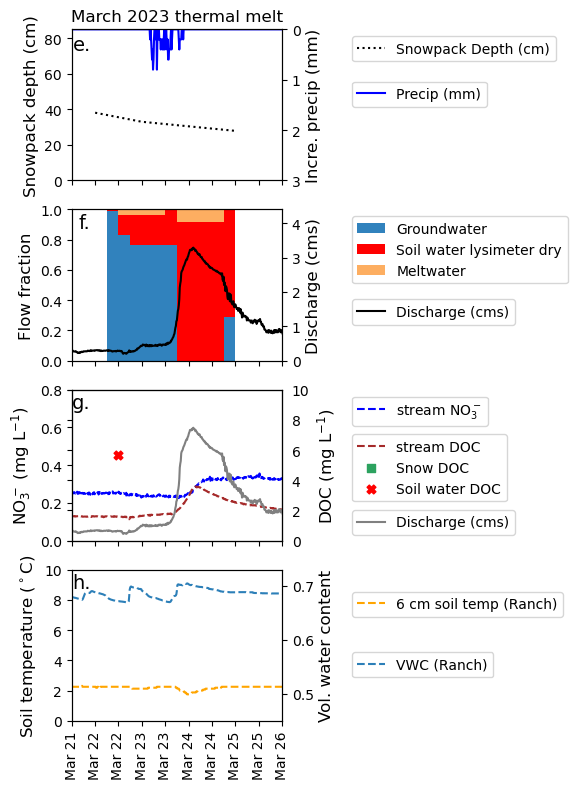

In [18]:
###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#################################
# Set site, tracers, endmembers #
#################################

Site = 'Wade'
#Month = 'February'
Month = 'March'
#Month = 'April'

# Tracers

if Site == 'Hungerford':
    tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']
    
if Site == 'Wade':
    tracers = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']
    
print(f"Tracers are {tracers}.")

# Endmembers
if Month == 'February':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
    
if Month == 'March':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
    
if Month == 'April':
    em_data = em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D
    

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-toc-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == Site) & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # If excluding pre-event
em_data = em_data[~em_data['Type'].isin(['Groundwater Bear Pond'])] # If using GW ave at Wade
em_data = em_data[~em_data['Type'].isin(['Groundwater High Pond'])] # If using GW ave at Wade
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs
em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter wet'])] # If using ave
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter dry'])] # If using ave
em_data = em_data[~em_data['Type'].isin(['Snowmelt lysimeter 2/15'])] #

# Load soil water and snowmelt DOC data from csv just for plotting
# The dates are artifical, but useful to fit on the EMMA time scales
em_toc_data = pd.read_csv("data/newrnet-chemistry/RI23-endmember-doc-plotting.csv")
em_toc_data = em_toc_data.loc[
    (em_toc_data['Site'] == Site)
]
em_toc_data['Datetime'] = (em_toc_data['Date'] + ' ' + em_toc_data['Time'])
em_toc_data['Datetime'] = pd.to_datetime(em_toc_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
# Define mapping of marker, color, and label by column Type
type_styles = {
    'Soil water lysimeter': {
        'color': 'red',
        'marker': 'X', # x marker
        'label': 'Soil water DOC'
    },
    'Snow': {
        'color': '#2ca25f',
        'marker': 's',  # square
        'label': 'Snow DOC'
    }
}

# Load q and s::can NO3 + TP data from csv
scan_data = pd.read_csv("~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/wb_q_chem.csv")

# Load scan_TOC data (mg/L) from csv
# Downloaded from Aquarius 05-19-2025 MED
toc_data = pd.read_csv("~//OneDrive/git-repos/EMMA/data/newrnet-q-scan/DOC.DOC@Wade_Brook.20221001.csv", comment='#')

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)
toc_data['ISO 8601 UTC'] = pd.to_datetime(toc_data['ISO 8601 UTC']).dt.tz_convert(None)

# Rename TOC columns for consistency
toc_data.rename(columns={'ISO 8601 UTC': 'datetime', 'Value': 'TOC'}, inplace=True)

# Load snowpack depth data from Mt Mansfield snow stake
#snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/snowpack/data/mansfield-noaa-WY22-WY23-3855342.csv")
#snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['DATE'], format="%Y-%m-%d %H:%M", errors="coerce")

# Load snowpack depth data from CoCoRaHS
snowpack_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/CleanedData/met-station/clean-cocorahs-vt-fr-30-20221115-20250414.csv")
snowpack_data['Date_clean'] = snowpack_data['Date'].str.strip()
snowpack_data['datetime'] = pd.to_datetime(snowpack_data['Date_clean'], format="%m/%d/%Y", errors="coerce")

# Load met data including precip
met_data = pd.read_csv("~//OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/wade_2020-2024_met_2024-11-08.csv")
met_data['Datetime'] = pd.to_datetime(met_data['Timestamp'], format = "%Y-%m-%d %H:%M:%S", errors = 'coerce')
met_data = met_data[met_data['Precip_Increm'].notna()] # Lots of missing (NA) precip in WWY23

# Load soil temperature and moisture data from Ranch Brook (Mansfield) SML1 site
soil_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/OriginalData/soil-sensors/Ranch_Brook/RanchBrook_TMS4_WY23_SML1_data.csv")
soil_data = soil_data.rename(columns={'Soil_temp': 'Temperature'})
soil_data['Datetime'] = pd.to_datetime(soil_data['dateTimeText'], format = "%Y.%m.%d %H:%M", errors = 'coerce')
filtered_1_soil = soil_data[soil_data['TMS_MED_number'] == 1]
filtered_2_soil = soil_data[soil_data['TMS_MED_number'] == 2]
filtered_3_soil = soil_data[soil_data['TMS_MED_number'] == 3]
filtered_4_soil = soil_data[soil_data['TMS_MED_number'] == 4]

#########
# PCA  #
#########

# Select the specific parameters from Site section (tracers)
selected_parametesr = tracers

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + tracers]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=tracers)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[tracers]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[tracers]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)

#######################
# VISUALIAZE THE EMMA #
#######################

# Filter data for samples in Event A
eventA_df = fractions_df[(fractions_df['Datetime'] >= '02/09/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/18/2023 00:00')]

#eventA_range = # Set x-axis limits for plot scope
start_A = pd.to_datetime("2023-02-09 00:00:00")
end_A = pd.to_datetime("2023-02-20 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_A = pd.to_datetime("2023-02-14 00:00:00")
end_plot_A = pd.to_datetime("2023-02-20 00:00:00")

# Filter data for samples in Event C
eventC_df = fractions_df[(fractions_df['Datetime'] >= '03/21/2023 00:00') \
                         & (fractions_df['Datetime'] <= '03/26/2023 00:00')]

#eventC_range = # Set x-axis limits for plot scope
start_C = pd.to_datetime("2023-03-21 00:00:00")
end_C = pd.to_datetime("2023-03-26 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_C = pd.to_datetime("2023-03-21 12:00:00")
end_plot_C = pd.to_datetime("2023-03-26 00:00:00")

# Filter data for samples in Event D
eventD_df = fractions_df[(fractions_df['Datetime'] >= '03/30/2023 00:00') \
                         & (fractions_df['Datetime'] <= '04/12/2023 00:00')]

#eventD_range = # Set x-axis limits for plot scope
start_D = pd.to_datetime("2023-03-30 00:00:00")
end_D = pd.to_datetime("2023-04-12 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_D = pd.to_datetime("2023-03-31 00:00:00")
end_plot_D = pd.to_datetime("2023-04-03 00:00:00")

# Set 'Datetime' as the index
eventA_df.set_index('Datetime', inplace=True)
eventC_df.set_index('Datetime', inplace=True)
eventD_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors_A = {'Groundwater ave': '#abdda4', \
          #'Soil water lysimeter wet': '#fa9fb5', \
          #'Soil water lysimeter dry': 'red',\
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}#,\
          #'Pre-event': '#3182bd'}

# Define colors for each endmember
colors_C = {'Groundwater ave': '#3182bd', \
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}\
          #'Pre-event': '#3182bd' }

# Define colors for each endmember
colors_D = {'Groundwater': '#abdda4', \
          'Soil water lysimeter wet': '#fa9fb5', \
          'Soil water lysimeter dry': 'red',\
          'Precip': '#3182bd',\
          'Snowmelt lysimeter 3/28': '#fdae61',\
          'Snowmelt lysimeter 4/12': '#ffeda0'}\
          #'Pre-event': '#3182bd' }

def plot_event_with_snowpack(
    event_df, event_name, colors, start, end, start_plot, end_plot, scan_data, snowpack_data, figsize=(6.5, 8)
):
    """
    Creates two stacked subplots:
    - Top: Snowpack depth and (eventually) rainfall data with two y-axes.
    - Bottom: Flow fractions, discharge, and nitrate.

    Parameters:
    - event_df: DataFrame containing data for the event, with Datetime as the index.
    - event_name: Name of the event (str) to use in the plot title.
    - colors: Dictionary mapping endmembers to colors.
    - start: Start datetime for the event.
    - end: End datetime for the event.
    - scan_data: DataFrame containing discharge and nitrate data.
    - snowpack_data: DataFrame containing snowpack depth data.
    - figsize: Tuple specifying figure size.
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=figsize, sharex=True)

    # Add subplot annotations in top-right corner using Axes coordinates
    ax1.annotate('e.', xy=(0.09, 0.86), xycoords='axes fraction', fontsize=14, ha='right')
    ax2.annotate('f.', xy=(0.09, 0.88), xycoords='axes fraction', fontsize=14, ha='right')
    ax3.annotate('g.', xy=(0.09, 0.88), xycoords='axes fraction', fontsize=14, ha='right')
    ax4.annotate('h.', xy=(0.09, 0.88), xycoords='axes fraction', fontsize=14, ha='right')

    ### Top subplot: Snowpack and eventually rainfall ###
    # Filter snowpack + rainfall data for the event duration
    snowpack_event = snowpack_data[(snowpack_data['datetime'] >= start) & (snowpack_data['datetime'] <= end)]
    precip_event = met_data[(met_data['Datetime'] >= start) & (met_data['Datetime'] <= end)]

    # Plot snowpack data on the primary y-axis
    ax1.plot(snowpack_event['datetime'], snowpack_event['snowpack_cm'], color='black', label='Snowpack Depth (cm)', linestyle=':')
    ax1.set_ylabel('Snowpack depth (cm)', color='black', fontsize = 12)
    ax1.set_ylim([0, 85])
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a secondary y-axis for rainfall
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(met_data['Datetime'], met_data['Precip_Increm'], color='blue', label='Precip (mm)')
    ax1_secondary.invert_yaxis()
    ax1_secondary.set_ylim([3, 0])
    ax1_secondary.set_ylabel('Incre. precip (mm)', color='black', fontsize = 12)
    ax1_secondary.tick_params(axis='y', labelcolor='black')
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.24, 0.8))

    # Set labels and legend
    #ax1.set_title(f'Snowpack depth and rainfall during {event_name}')
    ax1.set_title('March 2023 thermal melt', fontsize = 12)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.24, 1))

    ### Middle subplot: Flow fractions + discharge ###
    bottom = None
    for column, color in colors.items():
        ax2.bar(event_df.index, event_df[column], label=column, color=color, bottom=bottom, width=1)
        if bottom is None:
            bottom = event_df[column].values
        else:
            bottom += event_df[column].values

    # Map original column names to simplified legend labels
    legend_labels = {
    'Groundwater ave': 'Groundwater',
    'Baseflow': 'Groundwater',
    'Soil water lysimeter ave': 'Soil water',
    'Snowmelt lysimeter': 'Meltwater',
    'Snowmelt lysimeter ave': 'Meltwater'
    }

    # Build custom legend handles with simplified labels
    handles, labels = ax2.get_legend_handles_labels()
    simplified_labels = [legend_labels.get(lbl, lbl) for lbl in labels]

    #ax2.set_xlabel('Datetime')
    ax2.set_xlabel('')
    ax2.set_ylabel('Flow fraction', fontsize=12)
    ax2.set_xlim([start_plot, end_plot])
    ax2.legend(loc='upper left', bbox_to_anchor=(1.24, 1))
    #ax2.set_title(f'Fractional endmember contributions during {event_name}')
    ax2.tick_params(axis='x', rotation=30)

    # Secondary y-axis for discharge
    ax2_secondary = ax2.twinx()
    ax2_secondary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='black', label='Discharge (cms)', linestyle='-')
    ax2_secondary.set_ylabel('Discharge (cms)', color='black', fontsize = 12)
    ax2_secondary.set_ylim(0,4.4)
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.24, 0.55))

    # Plot discharge (again), NO3, and TOC on lower plot
    # Primary y-axis for nitrate
    ax3.plot(scan_data['datetime'], scan_data['NO3'], color='blue', label='stream NO$_3^-$', linestyle='--')
    ax3.set_ylabel('NO$_3^-$ (mg L$^{-1}$)', color='black', fontsize = 12)
    ax3.set_ylim(0,0.8)
    ax3.legend(loc='upper left', bbox_to_anchor=(1.5, 0.6))

    # Secondary y-axis for stream DOC
    ax3_secondary = ax3.twinx()
    ax3_secondary.plot(toc_data['datetime'], toc_data['TOC'], color='brown', label='stream DOC', linestyle='--')
    #ax3_secondary.scatter(streamwater_data['Datetime'], streamwater_data['TOC mg_L'], color = 'black', s = 10, label='Stream DOC')
    # Plot each type separately
    for t, group in em_toc_data.groupby('Type'):
        if t in type_styles:
            style = type_styles[t]
            ax3_secondary.scatter(
                group['Datetime'],
                group['TOC_mg_L'],
                color=style['color'],
                marker=style['marker'],
                s=40,
                label=style['label']
            )
    ax3_secondary.set_ylabel('DOC (mg L$^{-1}$)', color='black', fontsize = 12)
    ax3_secondary.set_ylim(0,10)

    # Tertiary axis for discharge (greyed out, no axis label needed)
    ax3_tertiary = ax3_secondary.twinx()
    ax3_tertiary.spines.right.set_position(("axes", 1.0))
    ax3_tertiary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='grey', label='Discharge (cms)', linestyle='-')
    ax3_tertiary.set_ylim([0, 4.4])
    ax3_tertiary.tick_params(axis='y', labelcolor='white')
    ax3_tertiary.set_yticks([])
    ax3_tertiary.tick_params(axis='x', rotation=90, color = 'white')
    
    # Fix secondary y-axis tick alignment after creating the tertiary axis
    ax3_secondary.tick_params(axis='y', labelright=True, labelleft=False)

    # Plot soil temperature and moisture on 4th plot
    ax4.plot(filtered_2_soil['Datetime'], filtered_2_soil['Temperature'], color='orange', label='6 cm soil temp (Ranch)', linestyle='--')
    ax4.set_ylabel('Soil temperature ($^\circ$C)', color='black', fontsize = 12)
    ax4.set_ylim([0, 10])
    ax4.tick_params(axis='y', labelcolor='black')
    ax4.tick_params(axis='x', rotation=90)
    ax4.legend(loc='upper left', bbox_to_anchor=(1.25, 0.65))

    # Secondary y-axis for soil VWR
    ax4_secondary = ax4.twinx()
    ax4_secondary.spines.right.set_position(("axes", 1.0))
    ax4_secondary.plot(filtered_2_soil['Datetime'], filtered_2_soil['VWC'], color='#2c7fb8', label='VWC (Ranch)', linestyle='--')
    ax4_secondary.set_ylabel('Vol. water content', color='black', fontsize = 12)
    ax4_secondary.set_ylim(0.45,0.73)
    ax4_secondary.legend(loc='upper left', bbox_to_anchor=(1.25, 0.25))

    # Plot all legends (overwrites some bad legend positions above)
    # Before plotting legends, shrink the plotting area to make space on the right
    plt.subplots_adjust(right=0.75)

    # Then fix all legends with the same x anchor
    ax1.legend(loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.7))

    ax2.legend(handles, simplified_labels, loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.45))

    ax3.legend(loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax3_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.75))
    ax3_tertiary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.25))

    ax4.legend(loc='upper left', bbox_to_anchor=(1.30, 0.9))
    ax4_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.5))


    # Define the formatter
    date_fmt = mdates.DateFormatter('%b %d')  # e.g., 'Feb 09'

    # Apply to all x-axes
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(date_fmt)

    plt.tight_layout()

    # --- Save plot as 'output/Site_EventName.jpg' ---
    # Sanitize filename: replace spaces and parentheses
    safe_event_name = event_name.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "")
    filename = f"{Site}_{safe_event_name}.jpg"
    output_path = os.path.join("output", filename)

    fig.savefig(output_path, dpi=300)
    print(f"Saved plot to: {output_path}")

    plt.show()

plot_event_with_snowpack(eventC_df, "Event C (Mar 22-26, 2023)", \
                         colors_C, start_C, end_C, start_plot_C, end_plot_C, scan_data, snowpack_data)

In [11]:
fractions_df.to_csv('Wade_WY23_MarTherm_EMMA_fractions.csv', index=False) 

fractions_df

,Sample ID,Site,Type,Datetime,Groundwater ave,Soil water lysimeter dry,Snowmelt lysimeter,Sum Fractions
0,RI23-1009,Wade,Grab/Isco,2023-02-15 15:00:00,1.000000e+00,1.054712e-15,5.551115e-17,1.0
1,RI23-1010,Wade,Grab/Isco,2023-02-15 19:00:00,9.262461e-01,1.712448e-16,7.375394e-02,1.0
2,RI23-1011,Wade,Grab/Isco,2023-02-15 23:00:00,8.154171e-01,6.938894e-17,1.845829e-01,1.0
3,RI23-1025,Wade,Grab,2023-02-15 12:00:00,9.200185e-01,-1.378015e-15,7.998152e-02,1.0
4,RI23-1012,Wade,Grab/Isco,2023-02-16 03:00:00,4.082202e-01,7.473270e-16,5.917798e-01,1.0
5,RI23-1014,Wade,Grab/Isco,2023-02-16 11:00:00,3.705246e-01,2.695094e-15,6.294754e-01,1.0
6,RI23-1028,Wade,Grab/Isco,2023-02-16 14:00:00,3.722572e-01,-3.961015e-14,6.277428e-01,1.0
7,RI23-1029,Wade,Grab/Isco,2023-02-16 20:00:00,3.487713e-01,1.571378e-14,6.512287e-01,1.0
8,RI23-1030,Wade,Grab/Isco,2023-02-17 02:00:00,5.175387e-01,-6.393758e-16,4.824613e-01,1.0
9,RI23-1031,Wade,Grab/Isco,2023-02-17 08:00:00,4.357926e-01,-6.039548e-16,5.642074e-01,1.0


## Event D: April freshet EMMA

<>:411: SyntaxWarning: invalid escape sequence '\c'
<>:411: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_52068/1478068276.py:411: SyntaxWarning: invalid escape sequence '\c'
  ax4.set_ylabel('Soil temperature ($^\circ$C)', color='black', fontsize = 12)


Tracers are ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L'].
Saved plot to: output/Wade_Event_D_Mar_30_-_Apr_12,_2023.jpg


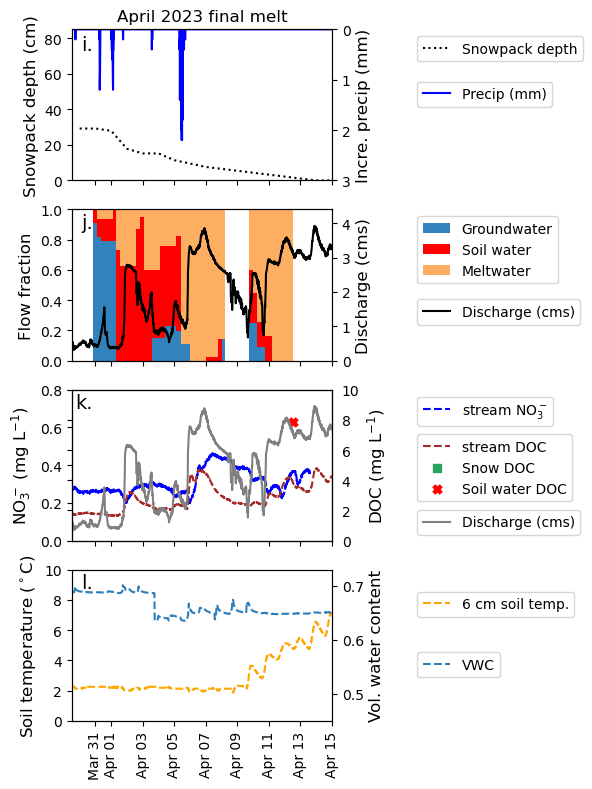

In [17]:
###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#################################
# Set site, tracers, endmembers #
#################################

Site = 'Wade'
#Month = 'February'
#Month = 'March'
Month = 'April'

# Tracers

if Site == 'Hungerford':
    tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']
    
if Site == 'Wade':
    tracers = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']
    
print(f"Tracers are {tracers}.")

# Endmembers
if Month == 'February':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
    
if Month == 'March':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
    
if Month == 'April':
    em_data = em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D
    

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-toc-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == Site) & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # If excluding pre-event
em_data = em_data[~em_data['Type'].isin(['Groundwater Bear Pond'])] # If using GW ave at Wade
em_data = em_data[~em_data['Type'].isin(['Groundwater High Pond'])] # If using GW ave at Wade
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter wet'])] # If using ave
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter dry'])] # If using ave
em_data = em_data[~em_data['Type'].isin(['Precip'])] #
em_data = em_data[~em_data['Type'].isin(['Snowmelt lysimeter'])] #

# Load soil water and snowmelt DOC data from csv just for plotting
# The dates are artifical, but useful to fit on the EMMA time scales
em_toc_data = pd.read_csv("data/newrnet-chemistry/RI23-endmember-doc-plotting.csv")
em_toc_data = em_toc_data.loc[
    (em_toc_data['Site'] == Site)
]
em_toc_data['Datetime'] = (em_toc_data['Date'] + ' ' + em_toc_data['Time'])
em_toc_data['Datetime'] = pd.to_datetime(em_toc_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
# Define mapping of marker, color, and label by column Type
type_styles = {
    'Soil water lysimeter': {
        'color': 'red',
        'marker': 'X', # x marker
        'label': 'Soil water DOC'
    },
    'Snow': {
        'color': '#2ca25f',
        'marker': 's',  # square
        'label': 'Snow DOC'
    }
}

# Load q and s::can NO3 + TP data from csv
scan_data = pd.read_csv("~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/wb_q_chem.csv")

# Load scan_TOC data (mg/L) from csv
# Downloaded from Aquarius 05-19-2025 MED
toc_data = pd.read_csv("~//OneDrive/git-repos/EMMA/data/newrnet-q-scan/DOC.DOC@Wade_Brook.20221001.csv", comment='#')

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)
toc_data['ISO 8601 UTC'] = pd.to_datetime(toc_data['ISO 8601 UTC']).dt.tz_convert(None)

# Rename TOC columns for consistency
toc_data.rename(columns={'ISO 8601 UTC': 'datetime', 'Value': 'TOC'}, inplace=True)

# Load snowpack depth data from Mt Mansfield snow stake
#snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/snowpack/data/mansfield-noaa-WY22-WY23-3855342.csv")
#snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['DATE'], format="%Y-%m-%d %H:%M", errors="coerce")

# Load snowpack depth data from CoCoRaHS
snowpack_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/CleanedData/met-station/clean-cocorahs-vt-fr-30-20221115-20250414.csv")
snowpack_data['Date_clean'] = snowpack_data['Date'].str.strip()
snowpack_data['datetime'] = pd.to_datetime(snowpack_data['Date_clean'], format="%m/%d/%Y", errors="coerce")

# Load met data including precip
met_data = pd.read_csv("~//OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/wade_2020-2024_met_2024-11-08.csv")
met_data['Datetime'] = pd.to_datetime(met_data['Timestamp'], format = "%Y-%m-%d %H:%M:%S", errors = 'coerce')
met_data = met_data[met_data['Precip_Increm'].notna()] # Lots of missing (NA) precip in WWY23

# Load soil temperature and moisture data from Ranch Brook (Mansfield) SML1 site
soil_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/OriginalData/soil-sensors/Ranch_Brook/RanchBrook_TMS4_WY23_SML1_data.csv")
soil_data = soil_data.rename(columns={'Soil_temp': 'Temperature'})
soil_data['Datetime'] = pd.to_datetime(soil_data['dateTimeText'], format = "%Y.%m.%d %H:%M", errors = 'coerce')
filtered_1_soil = soil_data[soil_data['TMS_MED_number'] == 1]
filtered_2_soil = soil_data[soil_data['TMS_MED_number'] == 2]
filtered_3_soil = soil_data[soil_data['TMS_MED_number'] == 3]
filtered_4_soil = soil_data[soil_data['TMS_MED_number'] == 4]

#########
# PCA  #
#########

# Select the specific parameters from Site section (tracers)
selected_parametesr = tracers

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + tracers]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=tracers)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[tracers]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[tracers]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)

#######################
# VISUALIAZE THE EMMA #
#######################

# Filter data for samples in Event A
eventA_df = fractions_df[(fractions_df['Datetime'] >= '02/09/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/18/2023 00:00')]

#eventA_range = # Set x-axis limits for plot scope
start_A = pd.to_datetime("2023-02-09 00:00:00")
end_A = pd.to_datetime("2023-02-20 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_A = pd.to_datetime("2023-02-14 00:00:00")
end_plot_A = pd.to_datetime("2023-02-20 00:00:00")

# Filter data for samples in Event C
eventC_df = fractions_df[(fractions_df['Datetime'] >= '03/21/2023 00:00') \
                         & (fractions_df['Datetime'] <= '03/26/2023 00:00')]

#eventC_range = # Set x-axis limits for plot scope
start_C = pd.to_datetime("2023-03-21 00:00:00")
end_C = pd.to_datetime("2023-03-26 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_C = pd.to_datetime("2023-03-21 12:00:00")
end_plot_C = pd.to_datetime("2023-03-26 00:00:00")

# Filter data for samples in Event D
eventD_df = fractions_df[(fractions_df['Datetime'] >= '03/30/2023 00:00') \
                         & (fractions_df['Datetime'] <= '04/12/2023 00:00')]

#eventD_range = # Set x-axis limits for plot scope
start_D = pd.to_datetime("2023-03-29 12:00:00")
end_D = pd.to_datetime("2023-04-15 00:00:00")

#eventA_range = # Set x-axis limits for plot vis
start_plot_D = pd.to_datetime("2023-03-29 12:00:00")
end_plot_D = pd.to_datetime("2023-04-15 00:00:00")

# Set 'Datetime' as the index
eventA_df.set_index('Datetime', inplace=True)
eventC_df.set_index('Datetime', inplace=True)
eventD_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors_A = {'Groundwater ave': '#3182bd', \
          #'Soil water lysimeter wet': '#fa9fb5', \
          #'Soil water lysimeter dry': 'red',\
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}#,\
          #'Pre-event': '#3182bd'}

# Define colors for each endmember
colors_C = {'Groundwater ave': '#3182bd', \
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}\
          #'Pre-event': '#3182bd' }

# Define colors for each endmember
colors_D = {'Groundwater ave': '#3182bd', \
          'Soil water lysimeter wet': 'red', \
          #'Soil water lysimeter dry': 'red',\
          #'Precip': '#3182bd',\
          'Snowmelt lysimeter 3/28': '#fdae61'}#,\
          #'Snowmelt lysimeter 4/12': '#ffeda0'}\
          #'Pre-event': '#3182bd' }

def plot_event_with_snowpack(
    event_df, event_name, colors, start, end, start_plot, end_plot, scan_data, snowpack_data, figsize=(6.5, 8)
):
    """
    Creates two stacked subplots:
    - Top: Snowpack depth and (eventually) rainfall data with two y-axes.
    - Bottom: Flow fractions, discharge, and nitrate.

    Parameters:
    - event_df: DataFrame containing data for the event, with Datetime as the index.
    - event_name: Name of the event (str) to use in the plot title.
    - colors: Dictionary mapping endmembers to colors.
    - start: Start datetime for the event.
    - end: End datetime for the event.
    - scan_data: DataFrame containing discharge and nitrate data.
    - snowpack_data: DataFrame containing snowpack depth data.
    - figsize: Tuple specifying figure size.
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=figsize, sharex=True)

    # Add subplot annotations in top-right corner using Axes coordinates
    ax1.annotate('i.', xy=(0.08, 0.86), xycoords='axes fraction', fontsize=14, ha='right')
    ax2.annotate('j.', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=14, ha='right')
    ax3.annotate('k.', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=14, ha='right')
    ax4.annotate('l.', xy=(0.08, 0.88), xycoords='axes fraction', fontsize=14, ha='right')

    ### Top subplot: Snowpack and eventually rainfall ###
    # Filter snowpack + rainfall data for the event duration
    snowpack_event = snowpack_data[(snowpack_data['datetime'] >= start) & (snowpack_data['datetime'] <= end)]
    precip_event = met_data[(met_data['Datetime'] >= start) & (met_data['Datetime'] <= end)]

    # Plot snowpack data on the primary y-axis
    ax1.plot(snowpack_event['datetime'], snowpack_event['snowpack_cm'], color='black', label='Snowpack depth', linestyle=':')
    ax1.set_ylabel('Snowpack depth (cm)', color='black', fontsize = 12)
    ax1.set_ylim([0, 85])
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a secondary y-axis for rainfall
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(met_data['Datetime'], met_data['Precip_Increm'], color='blue', label='Precip (mm)')
    ax1_secondary.invert_yaxis()
    ax1_secondary.set_ylim([3, 0])
    ax1_secondary.set_ylabel('Incre. precip (mm)', color='black', fontsize = 12)
    ax1_secondary.tick_params(axis='y', labelcolor='black')
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.24, 0.8))

    # Set labels and legend
    #ax1.set_title(f'Snowpack depth and rainfall during {event_name}')
    ax1.set_title('April 2023 final melt', fontsize = 12)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.24, 1))

    ### Middle subplot: Flow fractions + discharge ###
    bottom = None
    for column, color in colors.items():
        ax2.bar(event_df.index, event_df[column], label=column, color=color, bottom=bottom, width=1)
        if bottom is None:
            bottom = event_df[column].values
        else:
            bottom += event_df[column].values

    # Map original column names to simplified legend labels
    legend_labels = {
    'Groundwater ave': 'Groundwater',
    'Groundwater': 'Groundwater',
    'Soil water lysimeter dry': 'Soil water',
    'Soil water lysimeter wet': 'Soil water',
    'Snowmelt lysimeter': 'Meltwater',
    'Snowmelt lysimeter 3/28': 'Meltwater',
    'Snowmelt lysimeter 4/12': 'Meltwater'
    }

    # Build custom legend handles with simplified labels
    handles, labels = ax2.get_legend_handles_labels()
    simplified_labels = [legend_labels.get(lbl, lbl) for lbl in labels]

    #ax2.set_xlabel('Datetime')
    ax2.set_xlabel('')
    ax2.set_ylabel('Flow fraction', fontsize=12)
    ax2.set_xlim([start_plot, end_plot])
    # Update legend with cleaned labels
    ax2.legend(handles, simplified_labels, loc='upper left', bbox_to_anchor=(1.24, 1))
    #ax2.set_title(f'Fractional endmember contributions during {event_name}')
    ax2.tick_params(axis='x', rotation=30)

    # Secondary y-axis for discharge
    ax2_secondary = ax2.twinx()
    ax2_secondary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='black', label='Discharge (cms)', linestyle='-')
    ax2_secondary.set_ylabel('Discharge (cms)', color='black', fontsize = 12)
    ax2_secondary.set_ylim(0,4.4)
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.24, 0.55))

    # Plot discharge (again), NO3, and TOC on lower plot
    # Primary y-axis for nitrate
    ax3.plot(scan_data['datetime'], scan_data['NO3'], color='blue', label='stream NO$_3^-$', linestyle='--')
    ax3.set_ylabel('NO$_3^-$ (mg L$^{-1}$)', color='black', fontsize = 12)
    ax3.set_ylim(0,0.8)
    ax3.legend(loc='upper left', bbox_to_anchor=(1.5, 0.6))

    # Secondary y-axis for stream DOC
    ax3_secondary = ax3.twinx()
    ax3_secondary.plot(toc_data['datetime'], toc_data['TOC'], color='brown', label='stream DOC', linestyle='--')
    #ax3_secondary.scatter(streamwater_data['Datetime'], streamwater_data['TOC mg_L'], color = 'black', s = 10, label='Stream DOC')
    # Plot each type separately
    for t, group in em_toc_data.groupby('Type'):
        if t in type_styles:
            style = type_styles[t]
            ax3_secondary.scatter(
                group['Datetime'],
                group['TOC_mg_L'],
                color=style['color'],
                marker=style['marker'],
                s=40,
                label=style['label']
            )
    ax3_secondary.set_ylabel('DOC (mg L$^{-1}$)', color='black', fontsize = 12)
    ax3_secondary.set_ylim(0,10)

    # Tertiary axis for discharge (greyed out, no axis label needed)
    ax3_tertiary = ax3_secondary.twinx()
    ax3_tertiary.spines.right.set_position(("axes", 1.0))
    ax3_tertiary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='grey', label='Discharge (cms)', linestyle='-')
    ax3_tertiary.set_ylim([0, 4.4])
    ax3_tertiary.tick_params(axis='y', labelcolor='white')
    ax3_tertiary.set_yticks([])
    ax3_tertiary.tick_params(axis='x', rotation=90, color = 'white')
    
    # Fix secondary y-axis tick alignment after creating the tertiary axis
    ax3_secondary.tick_params(axis='y', labelright=True, labelleft=False)

    # Plot soil temperature and moisture on 4th plot
    ax4.plot(filtered_2_soil['Datetime'], filtered_2_soil['Temperature'], color='orange', label='6 cm soil temp.', linestyle='--')
    ax4.set_ylabel('Soil temperature ($^\circ$C)', color='black', fontsize = 12)
    ax4.set_ylim([0, 10])
    ax4.tick_params(axis='y', labelcolor='black')
    ax4.tick_params(axis='x', rotation=90)
    ax4.legend(loc='upper left', bbox_to_anchor=(1.25, 0.65))

    # Secondary y-axis for soil VWR
    ax4_secondary = ax4.twinx()
    ax4_secondary.spines.right.set_position(("axes", 1.0))
    ax4_secondary.plot(filtered_2_soil['Datetime'], filtered_2_soil['VWC'], color='#2c7fb8', label='VWC', linestyle='--')
    ax4_secondary.set_ylabel('Vol. water content', color='black', fontsize = 12)
    ax4_secondary.set_ylim(0.45,0.73)
    ax4_secondary.legend(loc='upper left', bbox_to_anchor=(1.25, 0.25))

    # Plot all legends (overwrites some bad legend positions above)
    # Before plotting legends, shrink the plotting area to make space on the right
    plt.subplots_adjust(right=0.75)

    # Then fix all legends with the same x anchor
    ax1.legend(loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.7))

    ax2.legend(handles, simplified_labels, loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.45))

    ax3.legend(loc='upper left', bbox_to_anchor=(1.30, 1.0))
    ax3_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.75))
    ax3_tertiary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.25))

    ax4.legend(loc='upper left', bbox_to_anchor=(1.30, 0.9))
    ax4_secondary.legend(loc='upper left', bbox_to_anchor=(1.30, 0.5))

    # Define the formatter
    date_fmt = mdates.DateFormatter('%b %d')  # e.g., 'Feb 09'

    # Apply to all x-axes
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(date_fmt)

    plt.tight_layout()

    # --- Save plot as 'output/Site_EventName.jpg' ---
    # Sanitize filename: replace spaces and parentheses
    safe_event_name = event_name.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "")
    filename = f"{Site}_{safe_event_name}.jpg"
    output_path = os.path.join("output", filename)

    fig.savefig(output_path, dpi=300)
    print(f"Saved plot to: {output_path}")

    plt.show()
plot_event_with_snowpack(eventD_df, "Event D (Mar 30 - Apr 12, 2023)", \
                         colors_D, start_D, end_D, start_plot_D, end_plot_D, scan_data, snowpack_data)

#plot_event_with_snowpack.savefig("/home/millieginty/Desktop/Wade_EMMA_D.png")

In [11]:
fractions_df.to_csv('Wade_WY23_AprFresh_EMMA_fractions.csv', index=False) 

fractions_df

,Sample ID,Site,Type,Datetime,Groundwater ave,Soil water lysimeter wet,Snowmelt lysimeter 3/28,Sum Fractions
0,RI23-1009,Wade,Grab/Isco,2023-02-15 15:00:00,1.000000e+00,1.609823e-15,6.106227e-16,1.0
1,RI23-1010,Wade,Grab/Isco,2023-02-15 19:00:00,1.000000e+00,2.442491e-15,2.331468e-15,1.0
2,RI23-1011,Wade,Grab/Isco,2023-02-15 23:00:00,9.090826e-01,-1.111277e-16,9.091744e-02,1.0
3,RI23-1025,Wade,Grab,2023-02-15 12:00:00,1.000000e+00,-9.436896e-16,-3.885781e-16,1.0
4,RI23-1012,Wade,Grab/Isco,2023-02-16 03:00:00,5.264334e-01,6.118993e-15,4.735666e-01,1.0
5,RI23-1014,Wade,Grab/Isco,2023-02-16 11:00:00,4.743230e-01,4.771432e-03,5.209055e-01,1.0
6,RI23-1028,Wade,Grab/Isco,2023-02-16 14:00:00,4.817750e-01,2.554123e-15,5.182250e-01,1.0
7,RI23-1029,Wade,Grab/Isco,2023-02-16 20:00:00,4.602651e-01,-1.242794e-15,5.397349e-01,1.0
8,RI23-1030,Wade,Grab/Isco,2023-02-17 02:00:00,5.935897e-01,5.397553e-02,3.524347e-01,1.0
9,RI23-1031,Wade,Grab/Isco,2023-02-17 08:00:00,5.446180e-01,4.119001e-15,4.553820e-01,1.0


In [13]:
# Load soil temperature and moisture data from Ranch Brook (Mansfield) SML1 site
soil_data = pd.read_csv("~//OneDrive/git-repos/LCBP_Soils/OriginalData/soil-sensors/Ranch_Brook/RanchBrook_TMS4_WY23_SML1_data.csv")
soil_data = soil_data.rename(columns={'Soil_temp': 'Temperature'})
soil_data['Datetime'] = pd.to_datetime(soil_data['dateTimeText'], format = "%Y.%m.%d %H:%M", errors = 'coerce')
filtered_1_soil = soil_data[soil_data['TMS_MED_number'] == 1]

filtered_1_soil

,row,dateTimeText,timeZone,Temperature,temperature2,Air_temp,moisturecounts,shake,ErrFlag,TMS_ID,VWC,TMS_MED_number,Datetime
0,0,2022.10.21 09:15,4,22.7500,22.5625,22.7500,377,202,0,09:15:00,-0.060098,1,2022-10-21 09:15:00
1,1,2022.10.21 09:30,4,23.0000,22.8750,23.0625,378,202,0,09:30:00,-0.059835,1,2022-10-21 09:30:00
2,2,2022.10.21 09:45,4,23.0625,23.1250,23.3125,379,202,0,09:45:00,-0.059573,1,2022-10-21 09:45:00
3,3,2022.10.21 10:00,4,23.1250,23.3125,23.5000,379,202,0,10:00:00,-0.059573,1,2022-10-21 10:00:00
4,4,2022.10.21 10:15,4,22.8750,23.2500,23.3750,378,202,0,10:15:00,-0.059835,1,2022-10-21 10:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19040,19040,2023.05.07 17:15,0,19.3125,19.6875,20.0000,410,202,0,17:15:00,-0.051429,1,2023-05-07 17:15:00
19041,19041,2023.05.07 17:30,0,19.3750,19.7500,20.0000,410,202,0,17:30:00,-0.051429,1,2023-05-07 17:30:00
19042,19042,2023.05.07 17:45,0,21.4375,21.1250,23.1250,417,202,0,17:45:00,-0.049589,1,2023-05-07 17:45:00
19043,19043,2023.05.07 18:00,0,21.3125,21.5000,22.6250,419,202,0,18:00:00,-0.049064,1,2023-05-07 18:00:00
